# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a tensor flow based deep learning classifier is built to classify the trafic signs. In the following, the steps for from loading and preprocessing the data, to building and testing a deep neural netwerk model are described. 

The training for this architecture is performed in Amazon Web Services (AWS) GPUs.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Loading data files

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file =  './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

# Number of training examples
n_train = y_train.shape[0]

# Number of validation examples
n_validation = y_valid.shape[0]

# Number of testing examples.
n_test = y_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualizing the German Traffic Signs Dataset using the pickled file(s). A few random example images are shown with the assgined labels on top.

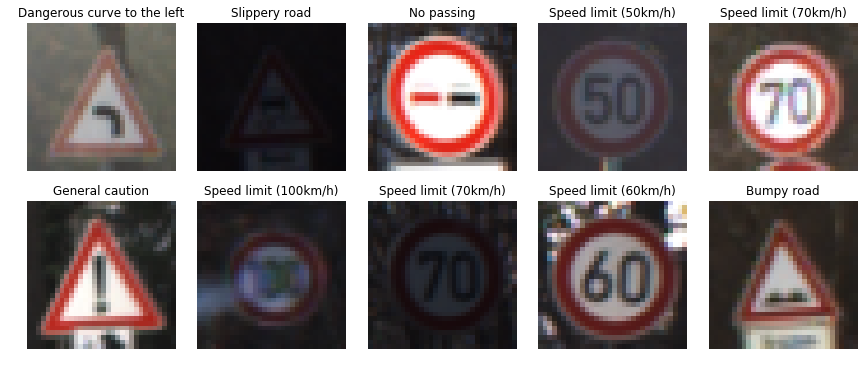

In [3]:
import matplotlib.pyplot as plt
import random
import csv

# Visualizations will be shown in the notebook.
%matplotlib inline

# Importing class labels
label=[]
ifile = open('signnames.csv', 'r')
reader = csv.reader(ifile)
for i,row in enumerate(reader):
    if i==0: continue
    label.append(row[1])


train_class_count = []
class_ind = []
for i in range(n_classes):
    train_class_count.append(len(y_train[y_train==i]))
    class_ind.append(i)
    
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    axs[i].imshow(image)
    axs[i].set_title(label[y_train[index]])
    axs[i].axis('off')

Minimum number of training images per class is: 180
Maximum number of training images per class is: 2010


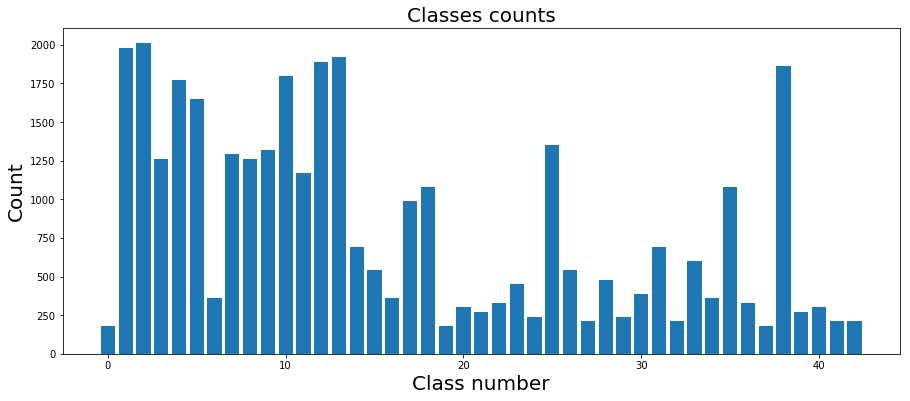

In [4]:
hist, bins = np.histogram(y_train, bins=n_classes)
fig, ax =plt.subplots(figsize=(15, 6))
classid = [i for i in range(n_classes)]
plt.bar(classid, hist, align='center')
ax.set_title('Classes counts', fontsize=20)
plt.xlabel('Class number', fontsize=20)
plt.ylabel('Count', fontsize=20)

print("Minimum number of training images per class is:", min(hist))
print("Maximum number of training images per class is:", max(hist))

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

The image data need to be pre-processed for high performance. The following are the pre-processing steps:

- As stated in [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), the images are converted to YUV and the Y (luminance) componenet is only used. This method worked better, compared to gray-scale conversion. The other possibility is to input all channels to the network which was not necassory for the implemented model

- The CV2 histogram equalizer function is used to equalize the histogram of the images. This method compensates for difference illumanation in the images.  

- Finally the image data are normalized to have zero mean and equal variance [-1, 1].

In [5]:
import cv2

def preprocess(img):
    image = img.copy()     
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    out = np.zeros((32,32,1))
    out[:,:,0] = (image[:,:,0] - 128.0) / 128.0
    return out

Checking the preprocessing on some sampled images from training data set:

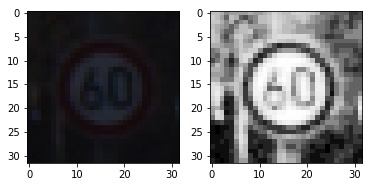

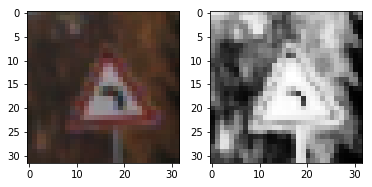

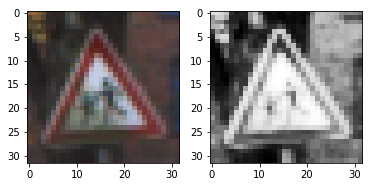

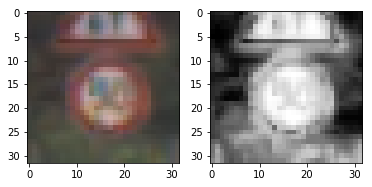

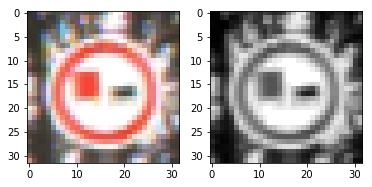

In [6]:
for i in range(5):
    im = X_train[random.randint(0, len(X_train)),:,:,:]
    plt.subplots(1,2, figsize=(6, 6))
    plt.subplot(1,2,1)
    plt.imshow(im)
    impro = preprocess(im)
    plt.subplot(1,2,2)
    plt.imshow(impro[:,:,0], cmap='gray')

Now all the training, validation and test set images are processed using the preprocessing function. 

In [7]:
X_train_n = np.zeros((n_train,32,32,1))
X_valid_n = np.zeros((n_validation,32,32,1))
X_test_n = np.zeros((n_test,32,32,1))
y_train_0 = y_train.copy()

for i in range(n_train):
    X_train_n[i, :, :, :] = preprocess(X_train[i,:,:,:])
    
for i in range(n_validation):
    X_valid_n[i, :, :, :] = preprocess(X_valid[i,:,:,:])
    
for i in range(n_test):    
    X_test_n[i, :, :, :] = preprocess(X_test[i,:,:,:])

### Data augmentation:
As is shown again here, the number of examples per label are not ballanced. The maximum example number per class is 2010 and minimum is 180. 

Minimum number of training images per class is: 180
Maximum number of training images per class is: 2010


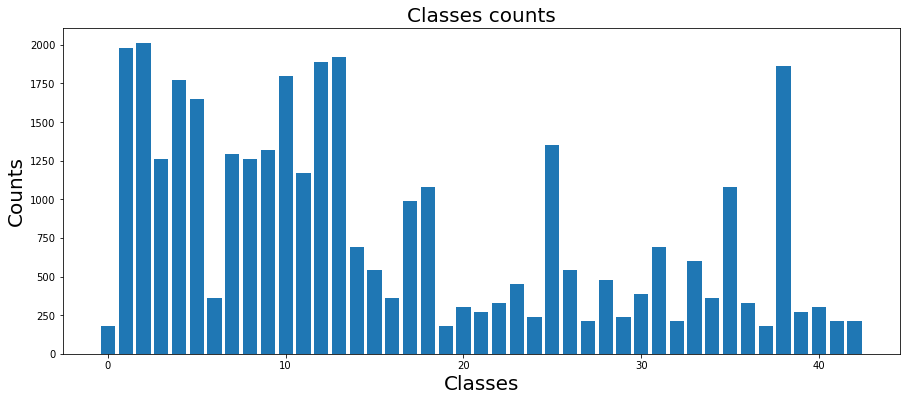

In [8]:
fig, ax =plt.subplots(figsize=(15, 6))
plt.bar(classid, hist, align='center')
ax.set_title('Classes counts', fontsize=20)
plt.xlabel('Classes', fontsize=20)
plt.ylabel('Counts', fontsize=20)

print("Minimum number of training images per class is:", min(hist))
print("Maximum number of training images per class is:", max(hist))

This could biase the predictions toward the more frequent classes. Therefore in this step, the image processing functions are built to create new examples from the original images.

The steps to create new example images are:
- Translating the image by a random number of pixels in [-3, 3] range.
- Rotating the image by a ranfom degree in [-10,10] range.
- Scaling the image by random transform pixels.
- Changing the brightness.

In [9]:
def translate(img):
    rows,cols,_ = img.shape
    px = 3
    dx,dy = np.random.randint(-px,px,2)
    M = np.float32([[1,0,dx],[0,1,dy]])
    trans = cv2.warpAffine(img,M,(cols,rows))
    trans = trans[:,:,np.newaxis]
    return trans

def rotate(img):
    rows,cols,_ = img.shape
    angvar = 30
    angle = np.random.randint(-angvar,angvar)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    rot = cv2.warpAffine(img,M,(cols,rows))
    rot = rot[:,:,np.newaxis]
    return rot

def scaling(img):   
    rows,cols,_ = img.shape    
    px = np.random.randint(-3,3) # transform pixels
    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])
    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    scaled = cv2.warpPerspective(img,M,(rows,cols))
    scaled = scaled[:,:,np.newaxis]
    return scaled

def brightness(img):
    img_max_value = 1.0/max(img.flatten())
    coef = np.random.uniform(img_max_value-0.05, img_max_value)
    br = img * coef
    return br

def augmentation(img):
    img2 = img.copy()
    img2 = translate(img2)
    img2 = rotate(img2)
    img2 = scaling(img2)
    img2 = brightness(img2)
    return img2

Here are a few examples of creating new examples from original image: 

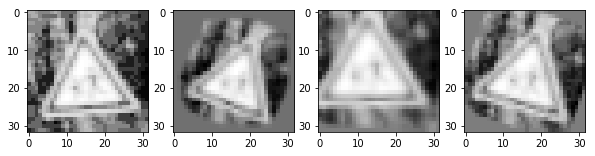

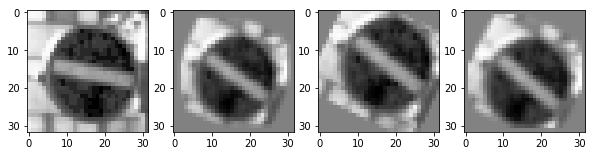

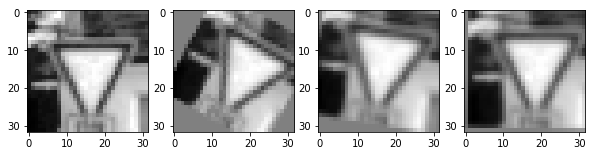

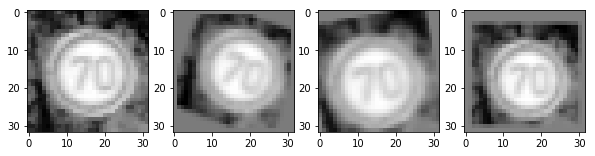

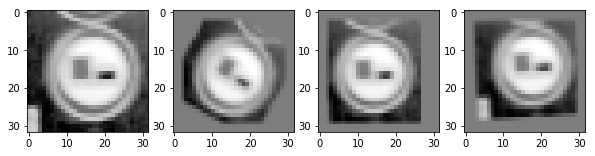

In [10]:
for i in range(5):
    im = X_train_n[random.randint(0, len(X_train)),:,:,:]
    plt.subplots(1,4, figsize=(10, 6))
    plt.subplot(1,4,1)
    plt.imshow(im[:,:,0], cmap='gray')
    impro = augmentation(im)
    plt.subplot(1,4,2)
    plt.imshow(impro[:,:,0], cmap='gray')
    impro = augmentation(im)
    plt.subplot(1,4,3)
    plt.imshow(impro[:,:,0], cmap='gray')
    impro = augmentation(im)
    plt.subplot(1,4,4)
    plt.imshow(impro[:,:,0], cmap='gray')

Finally, the labels with the number of examples below 800, are found and created new examples for them.

In [11]:
mintrainnum = 800
lowclasses = np.where(hist<mintrainnum)
for class_i in lowclasses[0]:
    class_indices = np.where(y_train == class_i)
    aug_indices = []
    numToAug = mintrainnum - len(class_indices[0])
    while numToAug>len(aug_indices):
        if numToAug - len(aug_indices) < len(class_indices[0]):
            aug_num = numToAug - len(aug_indices)
        else:
            aug_num = len(class_indices[0])
        aug_indices.extend(random.sample(list(class_indices[0]), aug_num))
    
    print('Augmenting class ', class_i, '...')
    for i in aug_indices:
        inimg = np.zeros((32,32,1))
        inimg[:,:, 0] = X_train_n[i,:,:,0]
        new_img = augmentation(inimg)
        X_train_n = np.concatenate((X_train_n, [new_img]), axis=0)
        y_train = np.concatenate((y_train, [class_i]), axis=0) 

Augmenting class  0 ...
Augmenting class  6 ...
Augmenting class  14 ...
Augmenting class  15 ...
Augmenting class  16 ...
Augmenting class  19 ...
Augmenting class  20 ...
Augmenting class  21 ...
Augmenting class  22 ...
Augmenting class  23 ...
Augmenting class  24 ...
Augmenting class  26 ...
Augmenting class  27 ...
Augmenting class  28 ...
Augmenting class  29 ...
Augmenting class  30 ...
Augmenting class  31 ...
Augmenting class  32 ...
Augmenting class  33 ...
Augmenting class  34 ...
Augmenting class  36 ...
Augmenting class  37 ...
Augmenting class  39 ...
Augmenting class  40 ...
Augmenting class  41 ...
Augmenting class  42 ...


In [14]:
print('New train X, y shapes:', X_train_n.shape, y_train.shape) 

New train X, y shapes: (46480, 32, 32, 1) (46480,)


The new histogram of the labels count is shown below

Maximum number of training examples per class: 2010
Minimum number of training examples per class: 800


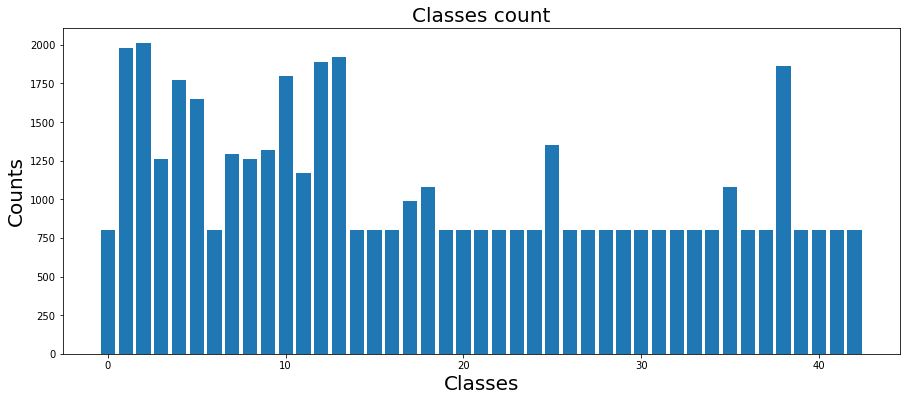

In [15]:
hist, bins = np.histogram(y_train, bins=n_classes)
fig, ax =plt.subplots(figsize=(15, 6))
classid = [i for i in range(n_classes)]
plt.bar(classid, hist, align='center')
ax.set_title('Classes count', fontsize=20)
plt.xlabel('Classes', fontsize=20)
plt.ylabel('Counts', fontsize=20)

print("Maximum number of training examples per class:", max(hist))
print("Minimum number of training examples per class:", min(hist))

### Model Architecture

The lenet, preception blocks and feedforward architectures are tested. However, the following architecture is found to exhibit the best performance. The architecture of this model is as following:

- (3x3)8 convolution --> Input = 32x32x1. Output = 30x30x8
- Relu 
- (3x3)16 convolution --> Output = 28x28x16
- Relu
- Max pool --> Output = 14x14x16
- (3x3)32 convolution  --> Output = 12x12x32
- Relu
- (3x3)32 convolution --> Output = 10x10x32
- Max pool --> Output = 5x5x32
- Flatten --> Output = 800
- 800x120 fully connected + drop-out --> Output = 120
- 120x84 Fully connected + drop-out --> Output = 84
- 84x43 Fully connected --> Output = 43

There one channel input image is fed into two Convolution layers followed by Relue. The output is max-pooled and fed to the two next Covolution-Relu layers. The output is again max-pooled and flattened to be input to the 3 fully connected classification layers. 

The better performance of this architecture is due to the relatively deep network and smaller convolution masks (3x3) which works better as the image size is small. The drop out technique is also used to avoid overfitting.

In [16]:
### Custom architecture is built.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def max_pool(x, k=2, stride=2):
    ksize = [1, k, k, 1]
    strides = [1, stride, stride, 1]
    padding = 'VALID'
    return tf.nn.max_pool(x, ksize, strides, padding)

global layer2 ## globalizing for visualization
global layer5 ## globalizing for visualization

def network(x):
    global layer2
    global layer5
    mu = 0
    sigma = 0.1
    
    
    weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 8), mean = mu, stddev = sigma)), ## convolution layer
    'wc2': tf.Variable(tf.truncated_normal(shape=(3, 3, 8, 16), mean = mu, stddev = sigma)), ## convolution layer
    'wc3': tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma)), ## convolution layer
    'wc4': tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma)), ## convolution layer
    'wd1': tf.Variable(tf.truncated_normal(shape=(800, 120), mean = mu, stddev = sigma)), ## fully connected layer
    'wd2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)), ## fully connected layer
    'out': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma)) ## output layer
    }

    biases = {
    'bc1': tf.Variable(tf.zeros([8])),
    'bc2': tf.Variable(tf.zeros([16])),
    'bc3': tf.Variable(tf.zeros([32])),
    'bc4': tf.Variable(tf.zeros([32])),
    'bd1': tf.Variable(tf.zeros([120])),
    'bd2': tf.Variable(tf.zeros([84])),
    'out': tf.Variable(tf.zeros([n_classes]))
    }
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x8.
    layer1 = conv2d(x, weights['wc1'], biases['bc1'], strides=1)

    # Layer 2: Convolutional. Output = 28x28x16.
    layer2 = conv2d(layer1, weights['wc2'], biases['bc2'], strides=1)
    
    # Pooling. Input = 28x28x16. Output = 14x14x16.
    layer3 = max_pool(layer2)
    
    # Layer 3: Convolutional. Output = 12x12x32.
    layer4 = conv2d(layer3, weights['wc3'], biases['bc3'], strides=1)
    
    # Layer 4: Convolutional. Output = 10x10x32.
    layer5 = conv2d(layer4, weights['wc4'], biases['bc4'], strides=1)
    
    # Pooling. Input = 10x10x32. Output = 5x5x32.
    layer6 = max_pool(layer5)
        
    # Flatten. Input = 5x5x32. Output = 800.
    layer6_flatten = flatten(layer6)
    
    # Layer 3: Fully Connected. Input = 800. Output = 120.
    layer7 = tf.add(tf.matmul(layer6_flatten, weights['wd1']), biases['bd1'])
    layer7 = tf.nn.dropout(layer7, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    layer8 = tf.add(tf.matmul(layer7, weights['wd2']), biases['bd2'])
    layer8 = tf.nn.dropout(layer8, keep_prob)
    
    # Layer 9: Fully Connected. Input = 84. Output = 10.
    layer9 = tf.add(tf.matmul(layer8, weights['out']), biases['out'])
    
    return layer9

### Train, Validate and Test the Model

x is the input that takes images and y is the output label. "keep_probe" is the probabilty of keeping units in the fully connected layers.

In [17]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units

one_hot_y = tf.one_hot(y, n_classes)

The mean of the cross-entrypy difference between the model prediction and ground truth labels are considered as the loss function to minimize. AdamOptimizer with rate '0.0009' is chosen to minimize the loss function.

In [18]:
### Train model here.
### Calculate and report the accuracy on the training and validation set.

rate = 0.0009
logits = network(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Evaluation
Creating evaluation operation by passing the evaluation data images in batches and averaging the accuracy of prediction. 

In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Training

The hyperparametr EPOCHS is chosen to be 20, that the validation accuracy becomes plateau, and the BATCH_SIZE is the best at 128 samples per batch.    

Training...

EPOCH 1 ...
Validation Accuracy = 0.891

EPOCH 2 ...
Validation Accuracy = 0.935

EPOCH 3 ...
Validation Accuracy = 0.964

EPOCH 4 ...
Validation Accuracy = 0.977

EPOCH 5 ...
Validation Accuracy = 0.980

EPOCH 6 ...
Validation Accuracy = 0.984

EPOCH 7 ...
Validation Accuracy = 0.984

EPOCH 8 ...
Validation Accuracy = 0.986

EPOCH 9 ...
Validation Accuracy = 0.983

EPOCH 10 ...
Validation Accuracy = 0.987

EPOCH 11 ...
Validation Accuracy = 0.989

EPOCH 12 ...
Validation Accuracy = 0.989

EPOCH 13 ...
Validation Accuracy = 0.992

EPOCH 14 ...
Validation Accuracy = 0.987

EPOCH 15 ...
Validation Accuracy = 0.992

EPOCH 16 ...
Validation Accuracy = 0.988

EPOCH 17 ...
Validation Accuracy = 0.990

EPOCH 18 ...
Validation Accuracy = 0.990

EPOCH 19 ...
Validation Accuracy = 0.993

EPOCH 20 ...
Validation Accuracy = 0.991

EPOCH 21 ...
Validation Accuracy = 0.991

EPOCH 22 ...
Validation Accuracy = 0.990

EPOCH 23 ...
Validation Accuracy = 0.989

EPOCH 24 ...
Validation Accura

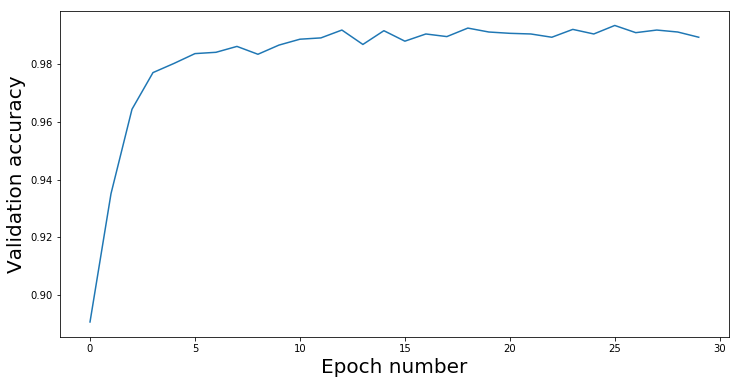

In [20]:
from sklearn.utils import shuffle

EPOCHS = 30
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_n)    
    print("Training...")
    print()
    validation_result = []
    train_result = []
    for i in range(EPOCHS):
        X_train_n, y_train = shuffle(X_train_n, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_n[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid_n, y_valid)
        train_result.append(evaluate(X_train_n, y_train))
        validation_result.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    fig,_ =plt.subplots(figsize=(12, 6))
    epochnum = [i for i in range(EPOCHS)]
        
    plt.plot(epochnum, validation_result)
    plt.xlabel('Epoch number', fontsize=20)
    plt.ylabel('Validation accuracy', fontsize=20)
    
    print("The final train accuracy is:", train_result[-1])
    print("The final validation accuracy is:", validation_result[-1])

    saver.save(sess, './custom_trafficSign_classifier')
    print("Model saved")

Evaluating the test accuracy:

In [21]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./custom_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    test_accuracy = evaluate(X_test_n, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.968


## Analysis of false predictions
To better analyse the error in predictions, the number of errors per class is identified. The histogram shows the counts of false prediction per class. The five classes with highest number of false predictions are listed.

In [22]:
import tensorflow as tf
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./custom_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    pred = sess.run(correct_prediction, feed_dict={x: X_test_n, y: y_test, keep_prob: 1})

The five classes with highest number of false predictions are:
1  -  Beware of ice/snow
2  -  Road work
3  -  End of speed limit (80km/h)
4  -  Keep right
5  -  General caution


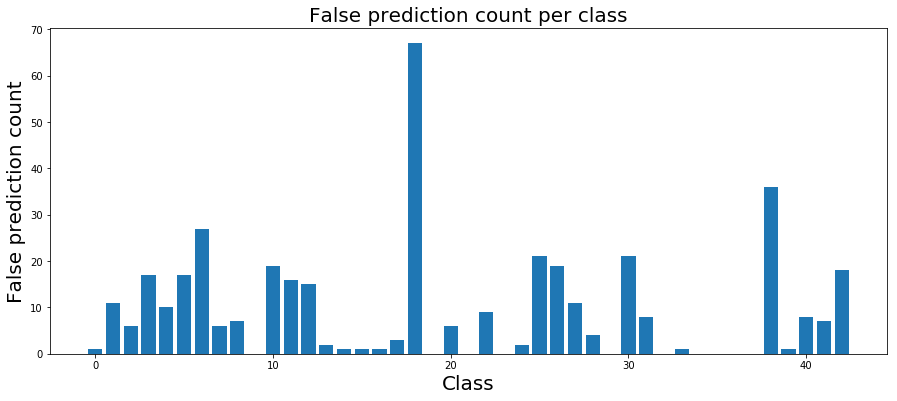

In [23]:
error_label = []
error_ind = []
for i in range(n_test):
    if pred[i] == False: 
        error_label.append(y_test[i])
        error_ind.append(i)

hist, bins = np.histogram(error_label, bins=n_classes)
fig, ax =plt.subplots(figsize=(15, 6))
plt.bar(classid, hist, align='center')
ax.set_title('False prediction count per class', fontsize=20)
plt.xlabel('Class', fontsize=20)
plt.ylabel('False prediction count', fontsize=20)

idx = np.argpartition(hist, -5)
max_errors_ind = idx[-5:]

print("The five classes with highest number of false predictions are:")

for i in range(5):
    print(i+1, ' - ', label[max_errors_ind[i]])

The misclassified images with the most number of prediction errors are shown below. Some of these images are hard to predict for human as well, because of the bad quality of the images. However, some identifiable images are also misclassified and we can increase the number of training examples for these images to increase accuracy on these classes.  

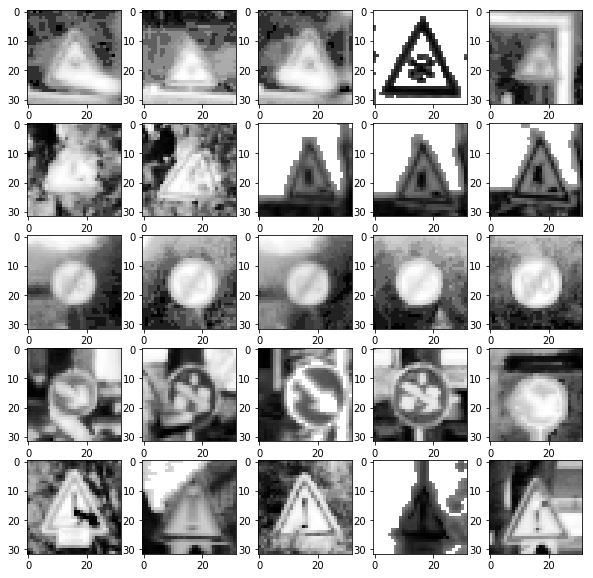

In [24]:
j = 0
plt.subplots(5,5, figsize=(10, 10))
for j in range(5):
    k=0
    for i in range(len(error_label)):
        if error_label[i] == max_errors_ind[j] and k<5:
            plt.subplot(5,5,j*5+k+1)
            plt.imshow(X_test_n[error_ind[i],:,:,0], cmap='gray')
            k=k+1

---

## Step 3: Test a Model on New Images

To give insight into how your model is working, five pictures of German traffic signs downloaded from Internet are fed into the model to predict the traffic sign type. Note that some of these signs classes were not in the training set.

### Load and Output the Images

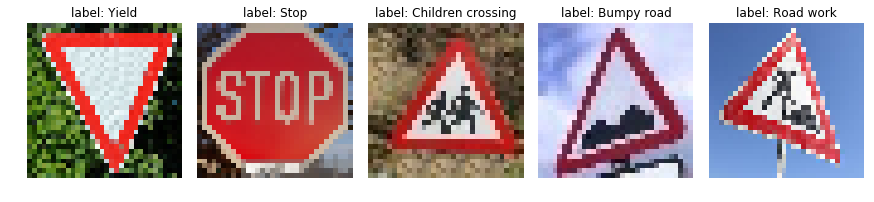

In [25]:
### Load the images and plot them here.
import os

def convertPixelSize(name):
    image = cv2.imread(name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    convimage = cv2.resize(image,(32,32))
    return convimage

fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

image_list = []
true_label = []
orig_image = []
j = -1


for i, name in enumerate(os.listdir("./newimages/")):
    if name != '.DS_Store': 
        j = j+1
    else:
        continue
    true_label.append(name.replace('.png',''))
    convimage = convertPixelSize("./newimages/"+name)
    orig_image.append(convimage)
    axs[j].imshow(convimage)
    axs[j].set_title('label: '+ str(true_label[j]))
    axs[j].axis('off')

image_list = [preprocess(image) for image in orig_image]

### Predict the Sign Type for Each Image

The train model is used to predict the label for the new images. The images and the predicted labels are shown.

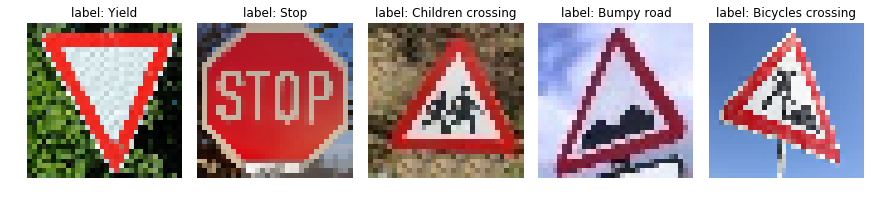

In [26]:
### Run the predictions here and use the model to output the prediction for each image.
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./custom_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    pred = sess.run(tf.argmax(logits, 1), feed_dict={x: image_list, keep_prob: 1})
    
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

for i in range(5):
    axs[i].imshow(orig_image[i])
    axs[i].set_title('label: '+ label[pred[i]])
    axs[i].axis('off')

### Analyze Performance
Predicting the accuracy of prediction for the five images. Only one image is misclassified.

In [27]:
new_accuracy = 0 
for i in range(5):
    if label[pred[i]] == true_label[i]:
        new_accuracy += 1./5.
print("New image accuracy is = {:.3f}".format(new_accuracy))

New image accuracy is = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In the following, for each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limited the output to the top 5 probabilities for each image). 

In [28]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./custom_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    top5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: image_list, keep_prob: 1})

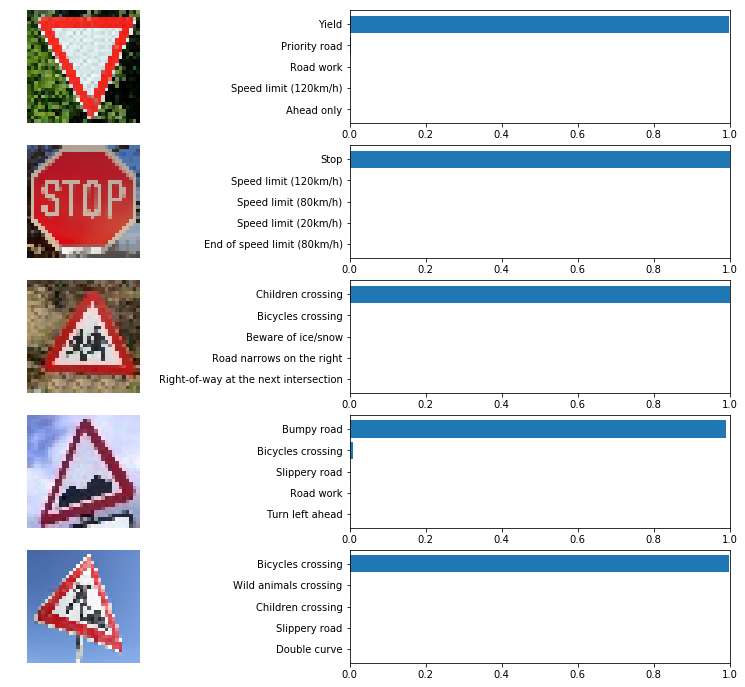

In [29]:
from matplotlib import gridspec

prediction_indices = top5.indices
pred_probs = top5.values
labels = np.asarray(true_label)

figure = plt.figure(figsize=(15 ,12))
grid = gridspec.GridSpec(5, 2)
for i,img in enumerate(orig_image):
    ax = plt.subplot(grid[i*2])
    plt.imshow(img, interpolation='nearest')
    ax.axis('off')
    probs = pred_probs[i]
    indices = [label[i] for i in prediction_indices[i]]
    ax = plt.subplot(grid[i*2 + 1])
    ax.barh(np.arange(5), probs)
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(indices)
    ax.invert_yaxis()
    ax.set_xlim(0,1.0)

Except the last image that is a false prediction, all the true predictions are with high probablity. Interestingly, the true class for the last image is "Road work" which is among the classes with the highest false prediction in the test set that was mentioned previously. 

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is an excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training the neural network we can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

The following function allows to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process.

In [30]:

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

The visulization of the input image (Yield class) after the first two (3x3) convolutions, is shown below for the 15 layers. The visualization shows that the boundries are the critical pixels.

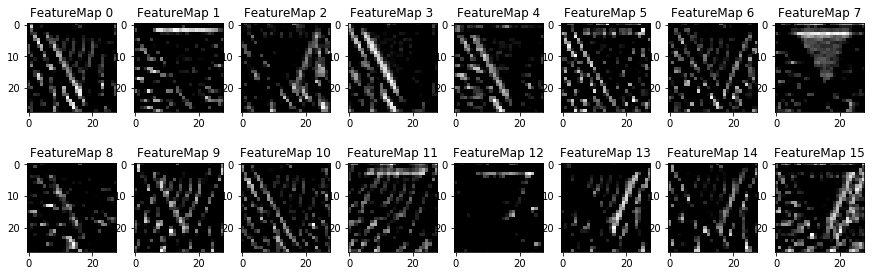

In [31]:
### Visualize network's feature maps here.

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./custom_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    model_input = [preprocess(image) for image in orig_image]
    tf_activation = layer2
    model_input = np.zeros((1,32,32,1))
    model_input[0,:,:,:] = image_list[0]
    outputFeatureMap(model_input, tf_activation)

The visulization of the input image after the forth convolution for 31 layers, is shown below. The visualization shows that the deeper levels contain more abstract informatio and recognizing the input image is defecult.

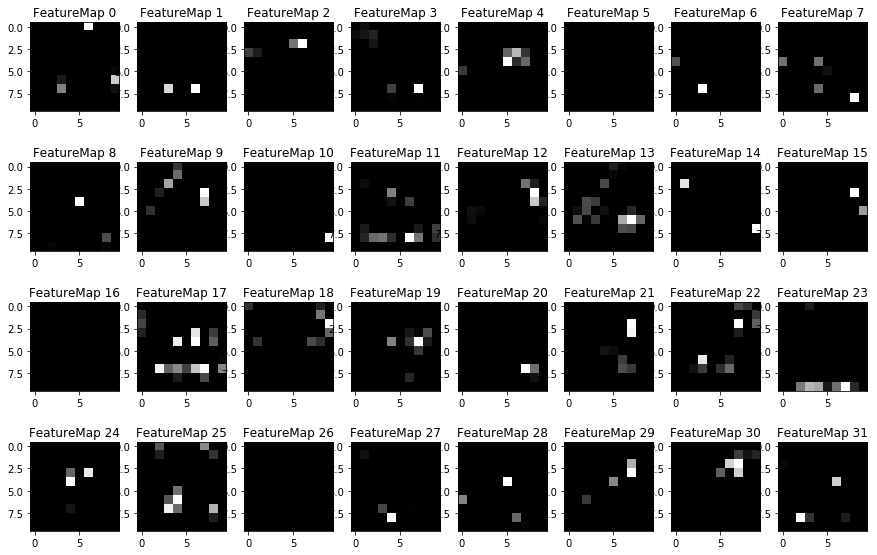

In [32]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./custom_trafficSign_classifier.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    model_input = np.zeros((1,32,32,1))
    model_input[0,:,:,:] = image_list[2]
    tf_activation = layer5
    outputFeatureMap(model_input, tf_activation, plt_num=1)